Example 1: Comparing KRAS Proteins
===================================


In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
import numpy as np

#from GW_prot import *


In [2]:
import sys
sys.path.insert(0,'../src')
from FGW_protein import *

Many of the PDB files in this dataset contain multple chains; we need to specify which chain is KRAS protein.

(This dataset has been curated as follows.....XXXXXX)

In [3]:
file_list = ['4dsn.pdb', '4dso.pdb', '4dst.pdb', '4epr.pdb', '4ept.pdb', '4epv.pdb', '4epw.pdb', '4epx.pdb','4epy.pdb', '4ldj.pdb',
 '4lpk.pdb', '4obe.pdb', '4obe.pdb', '4pzy.pdb', '4pzy.pdb', '4ql3.pdb', '4tq9.pdb', '4tq9.pdb', '4tqa.pdb', '4tqa.pdb', '5mla.pdb',
 '5mlb.pdb', '5mlb.pdb', '5mlb.pdb', '5mlb.pdb', '5o2s.pdb', '5o2s.pdb', '5o2s.pdb', '5o2s.pdb', '5o2t.pdb', '5ocg.pdb', '5tar.pdb',
 '5ufe.pdb']
chain_list = ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 
              'A', 'B', 'A', 'B', 'A', 'A', 'C', 'E', 'G', 'A', 'C', 'E', 'G', 'A', 'A', 'A', 'A']

We start by creating FGW_protein objects for each KRAS protein.

In [4]:
protein_list = [FGW_protein.make_protein_from_pdb(
    pdb_file = os.path.join("Examples Data/Example 1 - KRAS/" , file_list[i]), 
    chain_id = chain_list[i])
    for i in range(33)] 

We then initialize a `Stress_Comparison` object to compare these proteins using GW and their stresses.
In this example we store the transport plans in RAM for simplicity. This will use roughly 130 MB. 

In [5]:
import stress_comparison
A = stress_comparison.Stress_Comparison(prot_list = protein_list, RAM =  True)

We then run GW all-vs-all. On our computer with 16 parallel processes this take 5 seconds. With a single process it takes around 30 seconds. If we set `RAM = False` the computation time takes about twice as long as we need to write the data to files.

In [6]:
A.GW_compute_stresses(processes = 16)

We can study how the conformation of KRAS changes depending on the ligand it is bound to. These PDB files contain KRAS bound to guanosine diphosphate (GDP) and those bound to guanosine triphosphate-analogues (GNP, GCP, GSP).

In [7]:
ligand_list = ['GCP', 'GSP', 'GCP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP',  'GDP',
 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GSP', 'GDP', 'GDP',
 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GDP', 'GSP', 'GNP', 'GDP', 'GNP']

For this visual analysis, we will create a UMAP plot, with different colors corresponding to different ligands. 

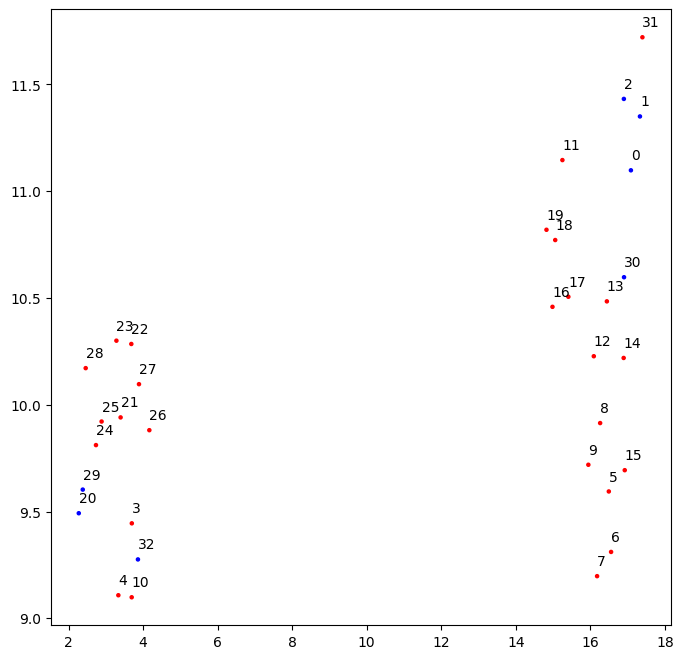

In [12]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt



distance_matrix = A.get_GW_dmat()

reducer = UMAP(metric = 'precomputed', random_state=1)

embedding = reducer.fit_transform(distance_matrix)
    
        
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c= ['red' if l == 'GDP' else 'blue' for l in ligand_list], s=5)
for i in range(33): 
    plt.annotate(str(i), (embedding[i, 0], embedding[i, 1] + 0.05)) 
  
plt.show()

#THIS LOOKS REALLY BAD!!! 
#probably because of ends cut 
# if we instead use the ends cut version it looks nicer

Next we use pymol to visualize the proteins and the stress levels of different residues in the proteins. 
`A.raw_stress_levels` contains the stresses of all the pairwise calculations, so we first average them for each protein.

In [9]:
avg_stresses_dict =  stress_comparison.normalize_stress_dict( A.raw_stress_dict)
avg_stresses_list = [avg_stresses_dict[name] for name in A.name_list]

pymol_protein_viewer.show_proteins_with_values(
    infiles = ["Examples Data/Example 1 - KRAS/" + file for file in file_list],
    chain_ids = chain_list,
    data_lists = avg_stresses_list,
    output_file = "Examples Data/Example 1 Outputs/KRAS stresses.pse")

![Screenshot](Examples Data/Example 1 Outputs/KRAS stresses screenshot.pdf) 

The pymol file we generate can then be opened in a pymol GUI window.
![Screenshot](Examples Data/Example 1 Outputs/KRAS stresses screenshot.pdf) 

For clarity we can also view a single protein at a time.



Next we will test how well the stress levels can be used to predict the switch I and switch II regions. These regions do not have well-defined endpoints but we will choose to use residues 30-40 and 60-72 in the canonical indexing respectively. 



In [ ]:
# needs to be adjusted
switch_regions = [i in range(30,40) or i in range(60,72) for i in range(140)]
#get AP_scores